# Analysis of Authors’ Institutional Affiliations (RePEc)

This notebook analyses the institutional affiliations of academic economists using RePEc data.

The objective is threefold:
1. Clean and harmonize affiliation shares at the author–institution level;
2. Describe the structure of affiliations (single vs. multiple affiliations);
3. Characterize the spatial and institutional concentration of authors across Europe.

Each observation corresponds to an author–institution link, with an associated affiliation share reflecting the relative importance of that institution for the author.



## 1. Data loading

We load the cleaned RePEc dataset containing information on authors, their institutional affiliations, and the relative weight of each affiliation.

The dataset is structured at the author–institution level: authors with multiple affiliations therefore appear several times.



In [27]:
import pandas as pd

In [28]:
df = pd.read_csv("data_A_Z.csv")

## 2. Cleaning affiliation shares

Affiliation shares are originally recorded as percentages, sometimes stored as strings and occasionally missing.

We convert all shares into numeric values and treat missing shares as single affiliations (100%), consistent with RePEc conventions.


In [29]:
df['share_pct'] = (
    df['share_pct']
    .astype(str)
    .str.replace('%', '', regex=False)
    .astype(float)
    .fillna(100)
)
df.head()

,author_name,short_id,institution,share_pct,location,repec_institution_id,author_url
0,"Antelius, Jesper",pan241,Riksrevisionen Government of Sweden,100.0,"Stockholm, Sweden",edi:srrgvse,https://ideas.repec.org/f/pan241.html
1,"Alan, Sule",pal184,Department of Economics European University In...,73.0,"Firenze, Italy",edi:deiueit,https://ideas.repec.org/e/pal184.html
2,"Antell, Jan Wilhelm",pan150,Hanken Svenska Handelshögskolan,100.0,"Helsinki, Finland",edi:shhhhfi,https://ideas.repec.org/e/pan150.html
3,"Antelo, Manel",pan291,Departamento de Fundamentos da Análise Económi...,100.0,"Santiago de Compostela, Spain",edi:dfusces,https://ideas.repec.org/f/pan291.html
4,"Antenord, Jean-Baptiste",pan582,Lille Économie et Management (LEM),100.0,"Lille, France",edi:laborfr,https://ideas.repec.org/f/pan582.html


In [30]:
n_obs = df.shape[0]
n_authors = df['short_id'].nunique()
n_institutions = df['repec_institution_id'].nunique()

n_obs, n_authors, n_institutions


(29295, 23949, 2708)

## 3. Constructed variables

We construct two key variables:
- `author_weight`: the fractional contribution of an author to an institution;
- `multi_affiliation`: an indicator equal to one if the author holds more than one affiliation.


In [31]:
# --- Constructed variables ---
df['author_weight'] = df['share_pct'] / 100
df['multi_affiliation'] = df['share_pct'] < 100



## 4. Single vs. multiple affiliations

We compute the share of authors holding at least one multiple affiliation.

This statistic provides a first measure of how prevalent cross-institutional mobility is in the profession.



In [32]:
share_multi = df.groupby('short_id')['multi_affiliation'].max().mean()
share_multi


np.float64(0.26527203641070607)

## 5. Descriptive statistics on affiliation intensity

We report summary statistics on affiliation shares and author weights to characterize the typical structure of affiliations.


In [33]:
desc_stats = pd.DataFrame({
    'Mean': df[['share_pct', 'author_weight']].mean(),
    'Median': df[['share_pct', 'author_weight']].median(),
    'Std. Dev.': df[['share_pct', 'author_weight']].std()
})

desc_stats


,Mean,Median,Std. Dev.
share_pct,76.813484,100.0,34.039899
author_weight,0.768135,1.0,0.340399


## 6. Institutional size and author concentration

We rank institutions by:
- the number of distinct affiliated authors;
- the weighted number of authors, accounting for multiple affiliations.

This allows us to distinguish between large institutions and institutions with highly concentrated affiliations.


In [34]:
authors_per_inst = (
    df.groupby('institution')['short_id']
      .nunique()
      .reset_index(name='n_authors')
      .sort_values('n_authors', ascending=False)
)

authors_per_inst.head(10)


,institution,n_authors
1803,Institute of Labor Economics (IZA),952
1955,Joint Research Centre European Commission,403
89,Banca d'Italia,375
145,CESifo,341
1074,European Central Bank,276
2268,Paris School of Economics,214
96,Banque de France,199
2650,ifo Institut - Leibniz-Institut für Wirtschaft...,190
2135,Leibniz-Zentrum für Europäische Wirtschaftsfor...,190
766,Deutsche Bundesbank,178


In [35]:
weighted_authors_per_inst = (
    df.groupby('institution')['author_weight']
      .sum()
      .reset_index(name='weighted_authors')
      .sort_values('weighted_authors', ascending=False)
)

weighted_authors_per_inst.head(10)


,institution,weighted_authors
1955,Joint Research Centre European Commission,385.94
89,Banca d'Italia,364.42
1074,European Central Bank,251.26
96,Banque de France,175.65
766,Deutsche Bundesbank,168.51
2268,Paris School of Economics,165.49
2613,Wydział Nauk Ekonomicznych Uniwersytet Warszawski,160.80
90,Banco de España,147.25
2135,Leibniz-Zentrum für Europäische Wirtschaftsfor...,146.21
2650,ifo Institut - Leibniz-Institut für Wirtschaft...,143.97


In [36]:
top_inst = authors_per_inst.merge(
    weighted_authors_per_inst,
    on='institution',
    how='left'
)

top_inst.head(10)


,institution,n_authors,weighted_authors
0,Institute of Labor Economics (IZA),952,129.01
1,Joint Research Centre European Commission,403,385.94
2,Banca d'Italia,375,364.42
3,CESifo,341,35.81
4,European Central Bank,276,251.26
5,Paris School of Economics,214,165.49
6,Banque de France,199,175.65
7,ifo Institut - Leibniz-Institut für Wirtschaft...,190,143.97
8,Leibniz-Zentrum für Europäische Wirtschaftsfor...,190,146.21
9,Deutsche Bundesbank,178,168.51


In [37]:
top_inst['share_authors'] = top_inst['n_authors'] / top_inst['n_authors'].sum()
top_inst['share_weighted'] = top_inst['weighted_authors'] / top_inst['weighted_authors'].sum()

top_inst['cum_share_authors'] = top_inst['share_authors'].cumsum()
top_inst['cum_share_weighted'] = top_inst['share_weighted'].cumsum()

top_inst.head(20)


,institution,n_authors,weighted_authors,share_authors,share_weighted,cum_share_authors,cum_share_weighted
0,Institute of Labor Economics (IZA),952,129.01,0.032500,0.005733,0.032500,0.005733
1,Joint Research Centre European Commission,403,385.94,0.013758,0.017151,0.046258,0.022884
2,Banca d'Italia,375,364.42,0.012802,0.016195,0.059060,0.039079
3,CESifo,341,35.81,0.011641,0.001591,0.070702,0.040670
4,European Central Bank,276,251.26,0.009422,0.011166,0.080124,0.051836
5,Paris School of Economics,214,165.49,0.007306,0.007354,0.087430,0.059190
6,Banque de France,199,175.65,0.006794,0.007806,0.094224,0.066996
7,ifo Institut - Leibniz-Institut für Wirtschaft...,190,143.97,0.006486,0.006398,0.100710,0.073394
8,Leibniz-Zentrum für Europäische Wirtschaftsfor...,190,146.21,0.006486,0.006497,0.107197,0.079892
9,Deutsche Bundesbank,178,168.51,0.006077,0.007488,0.113273,0.087380


## 7. Top institutions by number of affiliated authors

The following figure displays the ten institutions with the largest number of affiliated authors.

Bar lengths correspond to the number of distinct authors, ignoring affiliation weights.


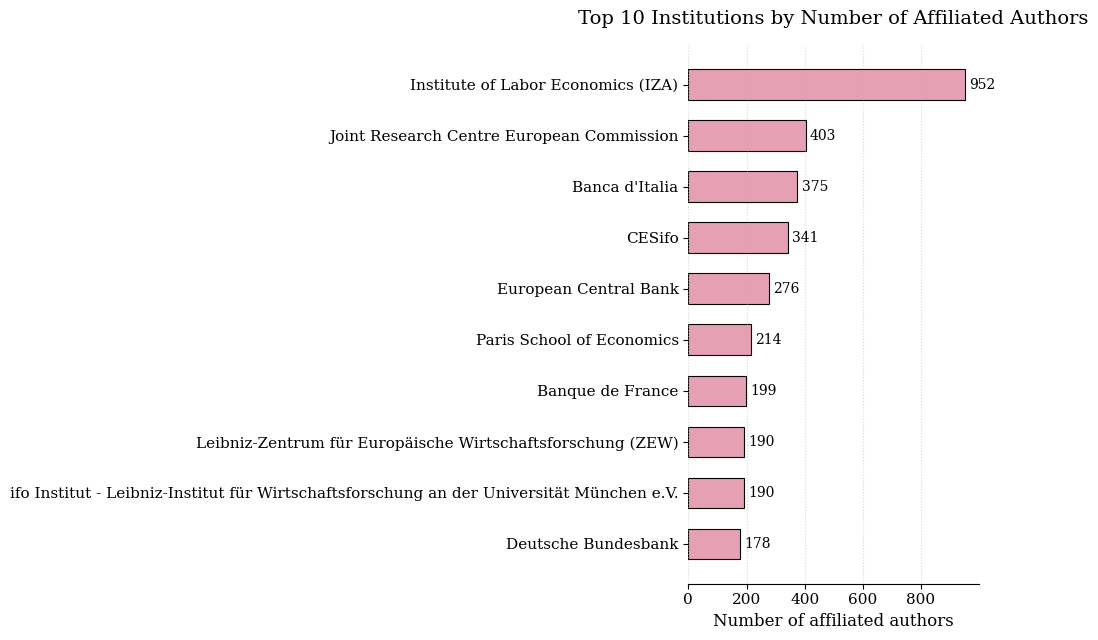

In [38]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Safe academic font (always available)
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],  # installed by default
    "axes.unicode_minus": False
})

# Sort data for clean visual hierarchy
top10 = top_inst.head(10).sort_values("n_authors")

fig, ax = plt.subplots(figsize=(10, 6.5))

bars = ax.barh(
    top10["institution"],
    top10["n_authors"],
    color="#E6A0B4",        # soft academic pink
    edgecolor="black",     # thin black border
    linewidth=0.8,
    height=0.6
)

# Labels and title
ax.set_xlabel("Number of affiliated authors", fontsize=12)
ax.set_title(
    "Top 10 Institutions by Number of Affiliated Authors",
    fontsize=14,
    pad=15
)

# Tick formatting
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)

# Remove unnecessary spines (keep bottom only)
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

# Light grid on x-axis only
ax.xaxis.grid(True, linestyle=":", linewidth=0.8, alpha=0.5)
ax.yaxis.grid(False)

# Add values at the end of bars
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 15,
        bar.get_y() + bar.get_height() / 2,
        f"{int(width)}",
        va="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()


## 8. Spatial distribution of affiliations

We exploit the location information to study the spatial concentration of affiliations across major European cities.

Cities are identified from institutional locations and manually matched to geographic coordinates.


In [39]:
df["city"] = (
    df["location"]
    .str.split(",")
    .str[0]
    .str.strip()
)


In [40]:
top_cities = (
    df["city"]
    .value_counts()
    .head(30)
)

top_cities


city
Paris                1826
Roma                 1142
Bonn                 1112
Madrid                731
München               717
Bucureşti             680
Milano                592
Barcelona             547
Warszawa              525
Berlin                513
Amsterdam             502
Wien                  498
Lisboa                463
Praha                 446
Sevilla               442
Budapest              424
Stockholm             408
Frankfurt am Main     392
Dublin                357
Lille                 340
Maastricht            314
Mannheim              310
Athens                295
Bruxelles/Brussel     281
København             248
Bologna               227
Frankfurt             225
Helsinki              224
Torino                223
Toulouse              212
Name: count, dtype: int64

In [41]:
city_coords = {
    "Paris": (48.8566, 2.3522),
    "Roma": (41.9028, 12.4964),
    "Bonn": (50.7374, 7.0982),
    "Madrid": (40.4168, -3.7038),
    "München": (48.1351, 11.5820),
    "Bucureşti": (44.4268, 26.1025),
    "Milano": (45.4642, 9.1900),
    "Barcelona": (41.3851, 2.1734),
    "Warszawa": (52.2297, 21.0122),
    "Berlin": (52.5200, 13.4050),
    "Amsterdam": (52.3676, 4.9041),
    "Wien": (48.2082, 16.3738),
    "Lisboa": (38.7223, -9.1393),
    "Praha": (50.0755, 14.4378),
    "Sevilla": (37.3891, -5.9845),
    "Budapest": (47.4979, 19.0402),
    "Stockholm": (59.3293, 18.0686),
    "Frankfurt am Main": (50.1109, 8.6821),
    "Dublin": (53.3498, -6.2603),
    "Lille": (50.6292, 3.0573),
    "Maastricht": (50.8514, 5.6900),
    "Mannheim": (49.4875, 8.4660),
    "Athens": (37.9838, 23.7275),
    "Bruxelles/Brussel": (50.8503, 4.3517),
    "København": (55.6761, 12.5683),
    "Bologna": (44.4949, 11.3426),
    "Frankfurt": (50.1109, 8.6821),
    "Helsinki": (60.1699, 24.9384),
    "Torino": (45.0703, 7.6869),
    "Toulouse": (43.6047, 1.4442),
}


In [42]:
df_map = df[df["city"].isin(city_coords)].copy()

df_map["lat"] = df_map["city"].map(lambda x: city_coords[x][0])
df_map["lon"] = df_map["city"].map(lambda x: city_coords[x][1])


In [43]:
df_map = (
    df_map
    .groupby(["city", "lat", "lon"])
    .agg(
        n_authors=("author_name", "nunique"),
        multi_aff_share=("multi_affiliation", "mean")
    )
    .reset_index()
)


In [48]:
import branca.colormap as cm
import folium
import random



In [44]:
color_dict = {
    "Low": "#deebf7",
    "Medium": "#9ecae1",
    "High": "#6baed6",
    "Very high": "#2171b5",
}


In [45]:

if "aff_bin" not in df_map.columns:
    df_map["aff_bin"] = pd.qcut(
        df_map["multi_aff_share"],
        q=4,
        labels=["Low", "Medium", "High", "Very high"],
        duplicates="drop"
    )


In [46]:
top_institutions = (
    df[df["city"].isin(df_map["city"])]
    .groupby(["city", "institution"])
    .size()
    .reset_index(name="n")
    .sort_values(["city", "n"], ascending=[True, False])
)

top_inst_city = (
    top_institutions
    .groupby("city")
    .head(3)
    .groupby("city")
    .apply(lambda x: "<br>".join(
        f"{row['institution']} ({row['n']})"
        for _, row in x.iterrows()
    ))
)


/tmp/ipykernel_152269/3882106154.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: "<br>".join(


## 9. Interactive map of European affiliation hubs

We construct an interactive map where:
- circle size reflects the number of affiliated authors;
- color intensity reflects the share of multi-affiliated authors.

This visualization highlights both institutional density and cross-institutional connectivity.


In [49]:
def radius(n):
    return min(25, 3 + np.sqrt(n) / 2)

def jitter(x, scale=0.18):
    return x + random.uniform(-scale, scale)


# ----------------------------
# 8. Création de la carte
# ----------------------------
m = folium.Map(
    location=[50, 10],
    zoom_start=4,
    tiles="CartoDB positron"
)


# ----------------------------
# 9. Ajout des cercles + labels
# ----------------------------
for _, row in df_map.iterrows():
    folium.CircleMarker(
        location=[
            jitter(row["lat"]),
            jitter(row["lon"])
        ],
        radius=radius(row["n_authors"]),
        color="black",
        weight=1,
        fill=True,
        fill_color=color_dict[row["aff_bin"]],
        fill_opacity=0.8,
        popup=f"""
        <b>{row['city']}</b><br>
        Authors: {row['n_authors']}<br>
        Multi-affiliation: {row['multi_aff_share']:.1%}<br><br>
        <b>Main institutions:</b><br>
        {top_inst_city.get(row['city'], 'N/A')}
        """

        
    ).add_to(m)

    # Label uniquement pour les hubs
    if row["city"] in top_cities.values:
        folium.Marker(
            location=[row["lat"], row["lon"]],
            icon=folium.DivIcon(
                html=f"""
                <div style="
                    font-size:11px;
                    font-weight:bold;
                    color:black;
                    text-align:center;
                ">
                {row['n_authors']}
                </div>
                """
            )
        ).add_to(m)


# ----------------------------
# 10. Légende personnalisée
# ----------------------------
legend_html = """
<div style="
position: fixed;
bottom: 30px;
left: 30px;
width: 200px;
background-color: white;
border: 2px solid grey;
z-index: 9999;
font-size: 12px;
padding: 10px;
">
<b>Multi-affiliation share</b><br>
<span style="color:#2171b5">●</span> Very high<br>
<span style="color:#6baed6">●</span> High<br>
<span style="color:#9ecae1">●</span> Medium<br>
<span style="color:#deebf7">●</span> Low<br>
<br>
<b>Circle size</b> ∝ number of authors
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

hub_labels = {
    "Paris": "PSE / CREST",
    "Bonn": "IZA",
    "London": "LSE",
    "Barcelona": "UPF",
    "Milan": "Bocconi",
}
if row["city"] in hub_labels:
    folium.Marker(
        location=[row["lat"], row["lon"]],
        icon=folium.DivIcon(
            html=f"""
            <div style="font-size:10px;color:#333;">
            {hub_labels[row['city']]}
            </div>
            """
        )
    ).add_to(m)



# ----------------------------
# 11. Titre
# ----------------------------
title_html = """
<h3 align="center" style="font-size:16px">
Spatial distribution of authors’ affiliations across major European cities
</h3>
"""
m.get_root().html.add_child(folium.Element(title_html))


# ----------------------------
# 12. Affichage / export
# ----------------------------
m

m.save("authors_affiliations_map_final.html")

## 10. Institutional concentration within Paris

We focus on the Paris area to study the internal structure of one of the largest academic hubs in Europe.

Rather than treating Paris as a single homogeneous location, we exploit the fine geographic granularity of the data (Paris and surrounding Île-de-France cities) to analyze how affiliations are distributed across institutions within the metropolitan area.

This analysis allows us to assess whether the Paris academic ecosystem is dominated by a small number of core institutions or instead characterized by a more decentralized and diversified structure. In doing so, it complements the cross-city comparison by providing a detailed within-city perspective on institutional concentration.


In [50]:
inst_city = (
    df.groupby(["city", "institution"])
    .size()
    .reset_index(name="n")
)

inst_city["share"] = inst_city.groupby("city")["n"].transform(
    lambda x: x / x.sum()
)


In [51]:
main_inst = (
    inst_city
    .sort_values(["city", "n"], ascending=[True, False])
    .groupby("city")
    .first()
    .reset_index()
    .rename(columns={
        "institution": "main_institution",
        "share": "main_inst_share"
    })
)


In [52]:
idf_cities = [
    "Paris",
    "Palaiseau",
    "Saclay",
    "Orsay",
    "Gif-sur-Yvette",
    "Massy",
    "Nanterre",
    "Créteil",
    "Saint-Denis",
    "Cachan",
    "Évry",
    "Versailles",
]


In [53]:
paris_inst = (
    df[df["city"].isin(idf_cities)]
    .groupby("institution")
    .size()
    .reset_index(name="n_authors")
    .sort_values("n_authors", ascending=False)
)

paris_inst["share"] = paris_inst["n_authors"] / paris_inst["n_authors"].sum()


In [55]:
paris_inst

,institution,n_authors,share
116,Paris School of Economics,214,0.095536
5,Banque de France,199,0.088839
64,EconomiX Université Paris-Nanterre (Paris X),128,0.057143
24,Centre de Recherche en Économie et Statistique...,111,0.049554
15,Centre d'Économie de la Sorbonne Université Pa...,109,0.048661
...,...,...,...
76,Groupe d'Études sur la Régulation et les Mutat...,1,0.000446
117,Paris École de Management,1,0.000446
109,Max Planck Sciences Po Center on Coping with I...,1,0.000446
122,Relations Globales Organisation de Coopération...,1,0.000446


## Conclusion

This analysis provides a structured overview of authors’ institutional affiliations using RePEc data, combining fractional affiliation measures, institutional rankings, and spatial analysis.

Three main results emerge. First, multiple affiliations are widespread: a non-negligible share of authors are connected to more than one institution, highlighting the importance of accounting for fractional author weights rather than relying solely on raw counts. Second, institutional size and influence differ depending on whether affiliations are measured in terms of distinct authors or weighted author shares, underscoring the relevance of fractionalization when comparing institutions. Third, the spatial analysis reveals strong geographic concentration in a limited number of European cities, combined with heterogeneous degrees of institutional dominance within cities.
